# Bank Customer Churn Analysis and Prediction
In this notebook we will perform a comprehensive analysis of bank customer churn data, including data exploration, preprocessing, model training, and evaluation. We'll build and compare two models to predict which customers are likely to leave the bank.


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib
import os

In [8]:
# Random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration
First, let's load the dataset and explore its characteristics.

In [9]:
# Loading the data using pandas df
df = pd.read_csv('Bank Customer Churn.csv')

In [10]:
# Display basic information
print("\nData Exploration:")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())


Data Exploration:
Dataset shape: (10000, 12)

First 5 rows:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  


The dataset consists of 10,000 rows and 12 columns, indicating that we have 10,000 customer records with 12 associated features (including the target variable churn).

First 5 Rows:
Features include a mix of demographic attributes (e.g., age, gender, country), account-related details (e.g., balance, products_number, tenure, credit_card, active_member), and a financial metric (estimated_salary).

The churn column is binary (0 or 1), indicating whether the customer churned.

Some customers have a balance of 0, suggesting they might not be actively using their accounts.

credit_card and active_member are likely binary indicators (0 = No, 1 = Yes).

Customers hold between 1 and 3 products, based on products_number.

In [11]:
# Display detailed information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None


No missing values are present in any of the columns (Non-Null Count = 10000 for all), which means we don't need to perform imputation or drop any rows/columns due to nulls. This allows us to proceed confidently to the next steps in data analysis and preprocessing.

Data types:

float64: 2 columns – likely continuous features (balance, estimated_salary).

int64: 8 columns – includes both discrete numerical features and binary indicators (credit_score, age, tenure, products_number, credit_card, active_member, churn, customer_id).

object: 2 columns – country and gender, which are categorical and will require encoding before feeding into machine learning models.

The customer_id column appears to be a unique identifier and does not carry predictive value, so it can be dropped during modeling.

In [12]:
print(df.describe())

        customer_id  credit_score           age        tenure        balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.4

The mean churn value is 0.2037, indicating that ~20.37% of customers have churned, while the remaining ~79.63% stayed. This confirms a class imbalance that we’ll need to address during modeling.

Mean age is ~39 years, with a wide range from 18 to 92.

The standard deviation (~10.5) suggests a good amount of variability across age groups.

Ranges from 350 to 850, which aligns with typical credit score scales.

The average customer has a credit score around 650, but the wide range suggests the need to assess whether lower credit scores are correlated with higher churn.

Notably, 25% of customers have a balance of 0, indicating they might not be actively using their accounts.

The maximum balance is ~250K, while the mean is ~76.5K, showing significant variation.

These inactive customers with zero balance may contribute disproportionately to churn.

Number of years with the bank ranges from 0 to 10, with a median of 5 years.

It appears fairly evenly distributed; we’ll later assess if loyalty correlates with lower churn.

Salaries range from ~11 to 200K, with a median around 100K, showing a broad economic representation.

Most customers have 1 product (25%, 50%, and 75% percentiles all at 1), which may indicate low engagement.

We'll investigate whether customers with fewer products are more likely to churn.

Around 70.5% have a credit card, and 51.5% are active members.

The balance in these features allows us to examine whether being an active member or holding a credit card reduces churn risk.

# 2. Data Visualization
## Now, let's visualize various aspects of the data to gain insights about factors affecting churn.

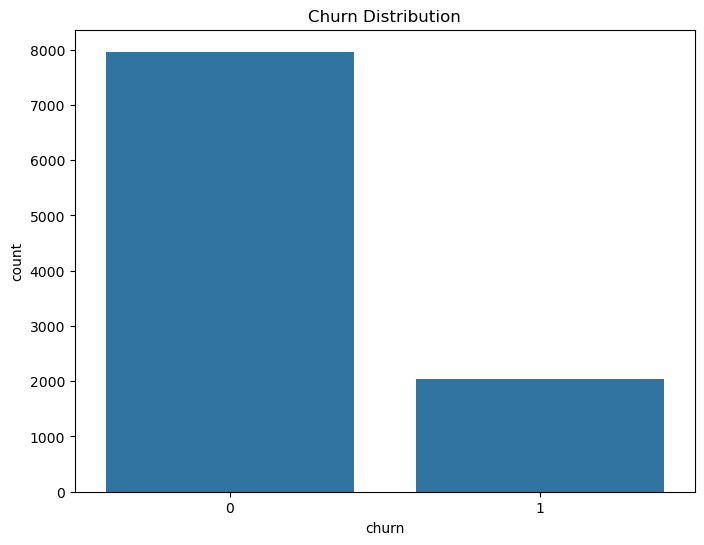

In [13]:
# Create a directory for saving figures
if not os.path.exists('figures'):
    os.makedirs('figures')

# Plot churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution')
plt.savefig('figures/churn_distribution.png')
plt.show()

The bar chart above shows the distribution of churned (1) vs. non-churned (0) customers:

A large majority of customers (≈ 80%) are non-churned, represented by class 0.

Only about 20% of the customers are churned, represented by class 1.

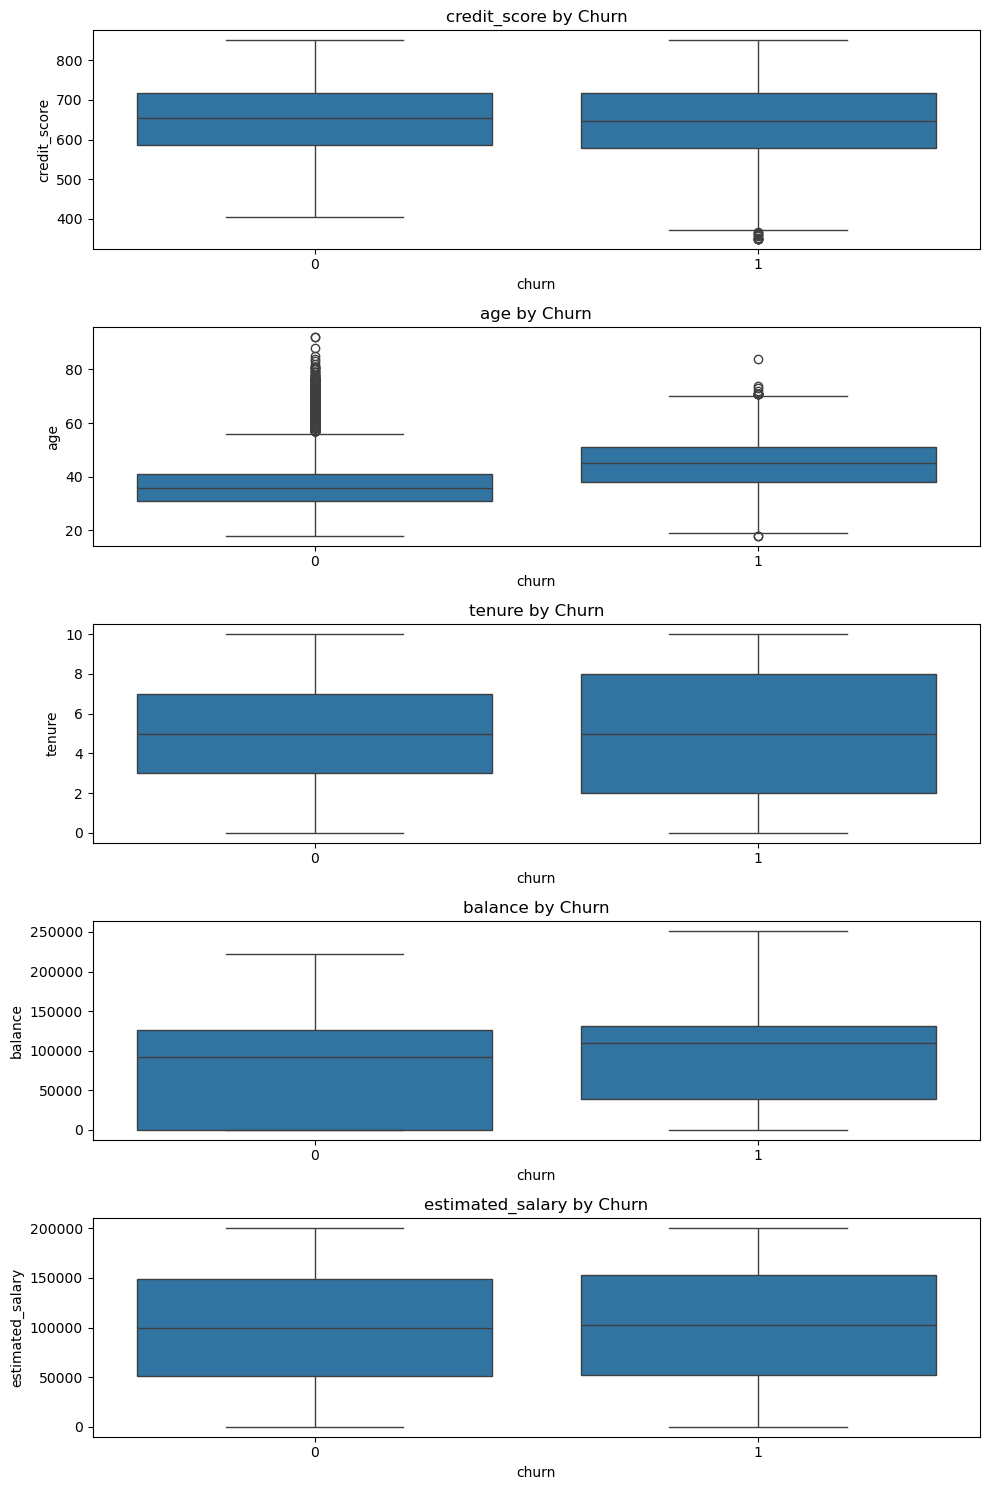

In [14]:
# Define the list of numerical features to analyze in relation to churn
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 15))

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='churn', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Churn')

plt.tight_layout()
plt.savefig('figures/numerical_features_by_churn.png')
plt.show()

These box plots visualize the distribution of key numerical features between customers who churned (1) and those who did not churn (0):

1. credit_score by Churn
The median credit score is slightly lower for churned customers.

2. age by Churn
Churned customers tend to be older on average, with the median and interquartile range higher than for non-churned customers.

3. tenure by Churn
No major difference in the distribution of tenure across the two groups.

4. balance by Churn
Both churned and non-churned customers exhibit a wide range of balances, but the medians are similar.

5. estimated_salary by Churn
Distribution is fairly uniform across both groups, with no clear pattern.

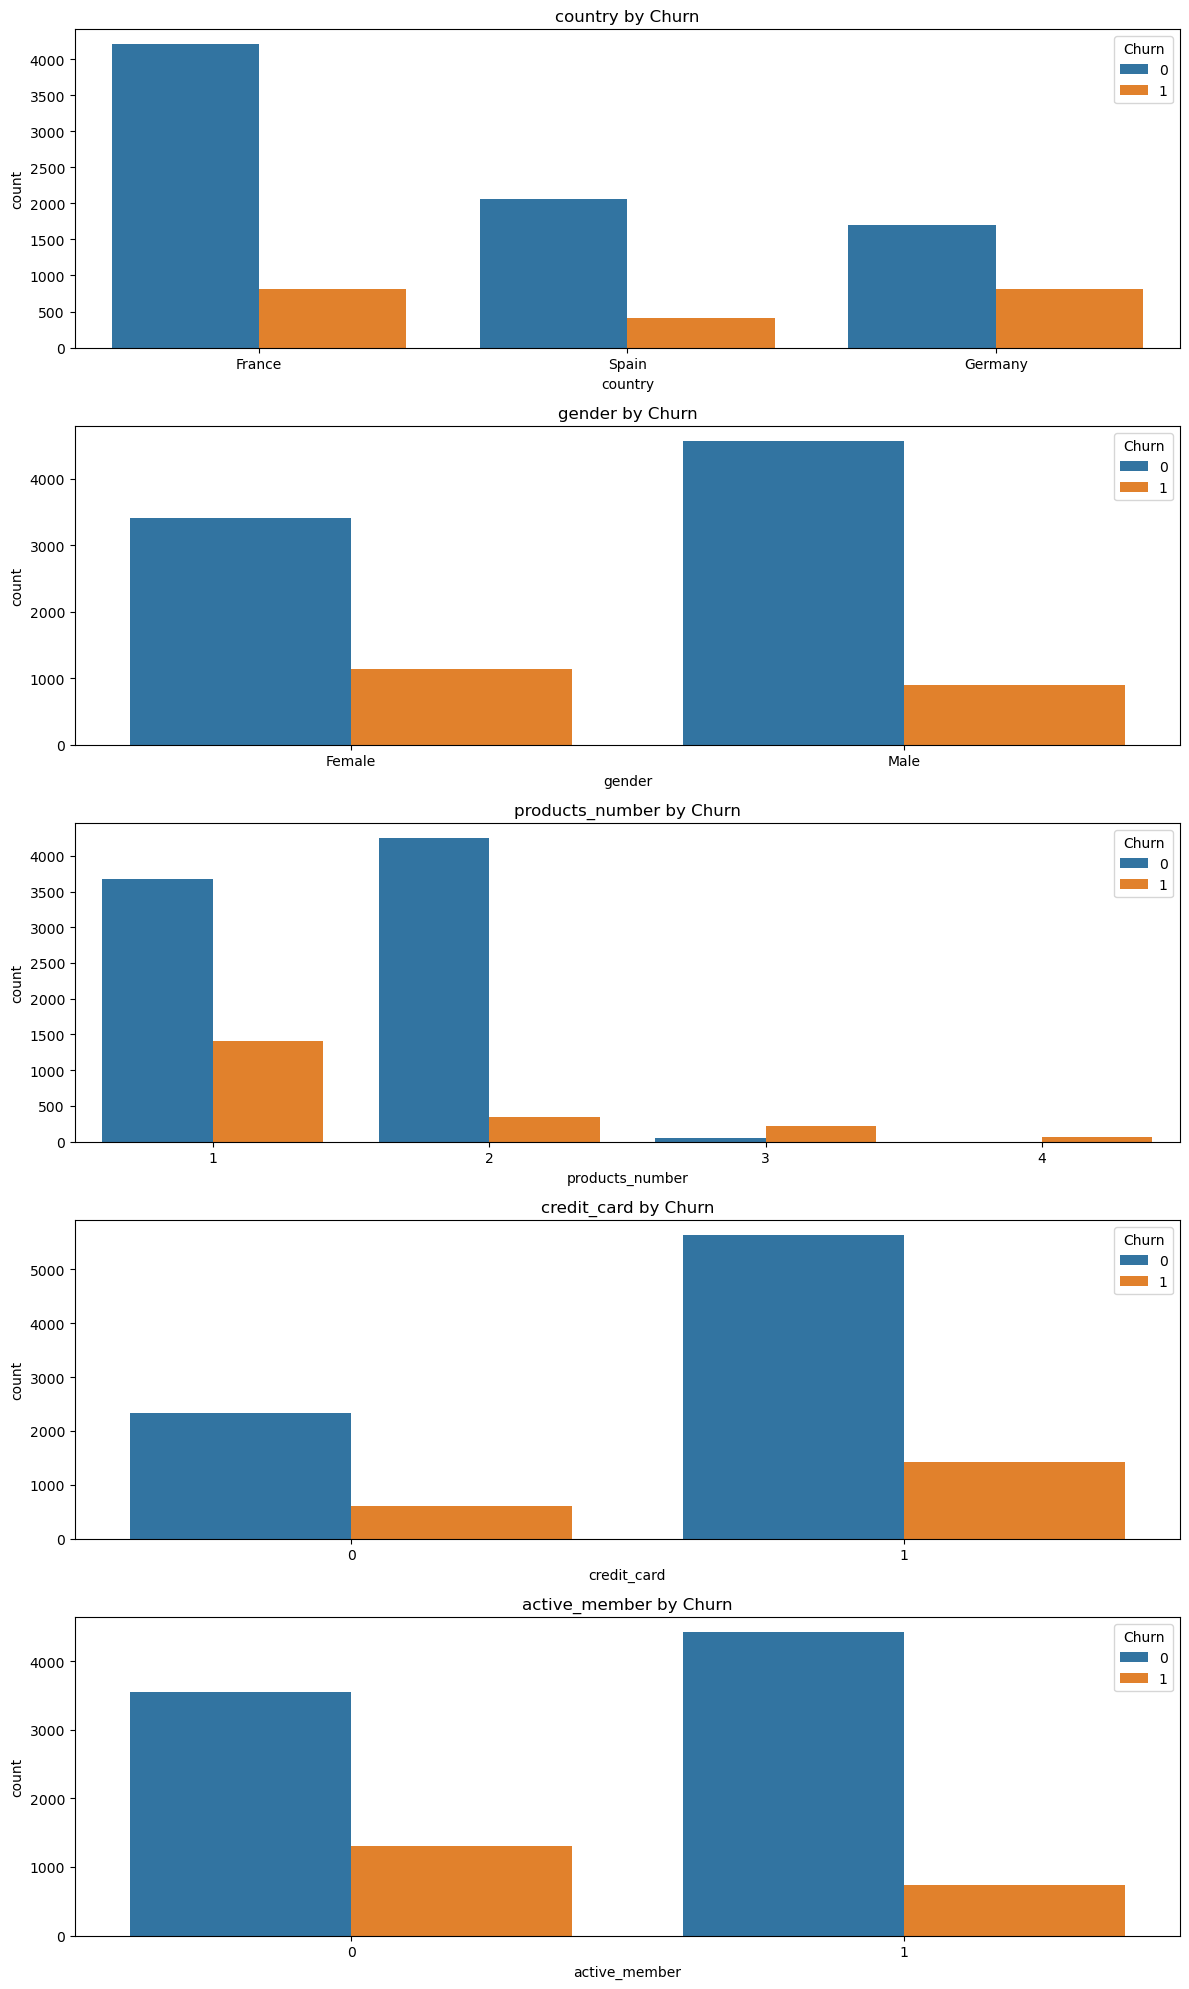

In [15]:
# Categorical features distribution by churn
categorical_features = ['country', 'gender', 'products_number', 'credit_card', 'active_member']
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(12, 20))

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='churn', data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Churn')
    axes[i].legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.savefig('figures/categorical_features_by_churn.png')
plt.show()

Country, gender, number of products, and active member status are potentially strong features for predicting churn.

Credit card ownership appears to be a weak predictor.

For modeling purposes, interactions between these categorical features and numerical ones like age and balance may further enhance predictive performance.

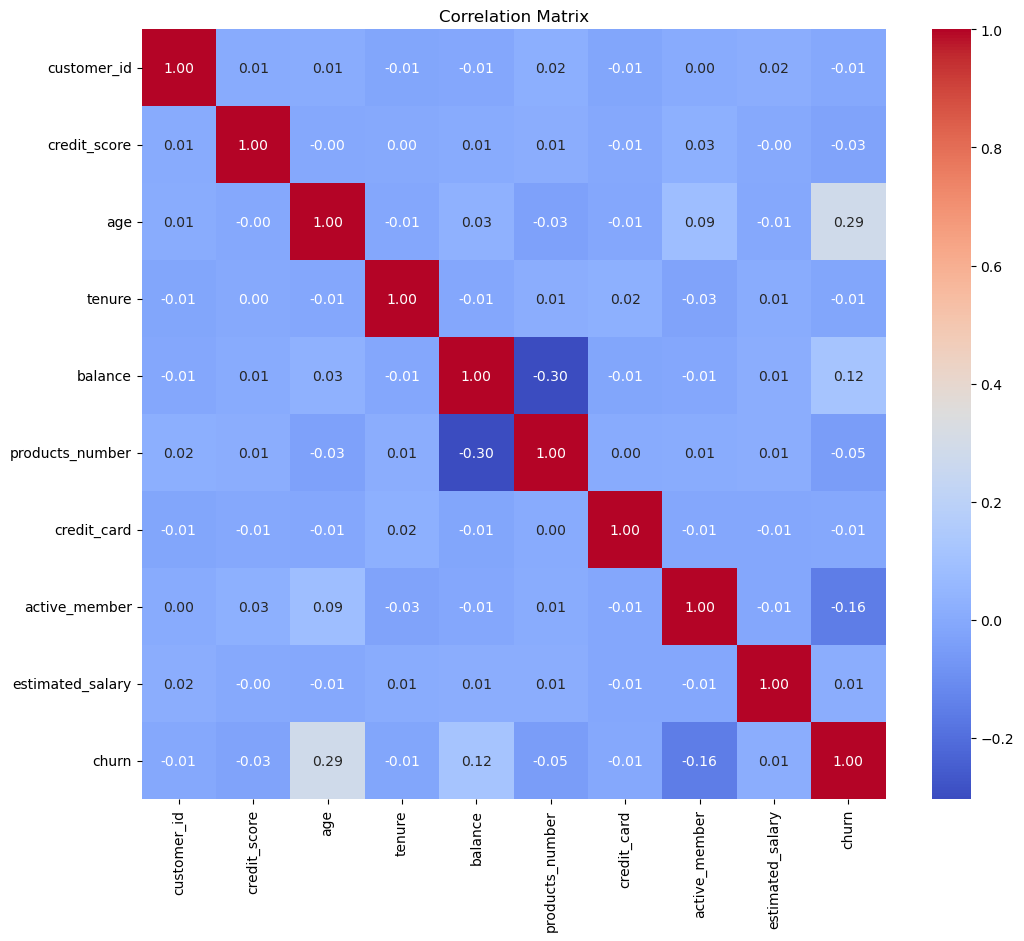

In [16]:
# Correlation matrix
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('figures/correlation_matrix.png')
plt.show()

This heatmap shows Pearson correlation coefficients between features and the churn label. We notice:

age shows the strongest positive correlation with churn (+0.29), Older customers are more likely to churn.

active_member has a moderate negative correlation (−0.16), Active members are less likely to churn.

balance and products_number show weak correlations (+0.12 and −0.05, respectively).

credit_score, tenure, estimated_salary, and credit_card have very low or near-zero correlation with churn.

balance and products_number are negatively correlated (−0.30)—possibly indicating higher product usage relates to lower balances.

Most features are weakly correlated with each other, indicating low multicollinearity, which is good for modeling.

Features like age, active_member, and balance might carry predictive value for churn.

The low inter-feature correlations suggest no urgent need for dimensionality reduction techniques like PCA.

While credit_score and tenure don't show strong linear correlation with churn, they may still contribute non-linear relationships in tree-based models.

# 3. Data Preprocessing
## Now we'll prepare our data for modeling, including feature encoding and addressing class imbalance if it exists.

In [19]:
# We will drop customer_id as it's just an identifier
X = df.drop(['customer_id', 'churn'], axis=1)
y = df['churn']

In [20]:
# Define categorical and numerical features
categorical_features = ['country', 'gender']
numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'products_number',
                      'credit_card', 'active_member', 'estimated_salary']

In [21]:
# Create a preprocessing pipeline using ColumnTransformer
# This will apply different transformations to numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to numerical features
        # StandardScaler standardizes the data to have mean = 0 and std deviation = 1
        ('num', StandardScaler(), numerical_features),

        # Apply OneHotEncoder to categorical features
        # drop='first' avoids multicollinearity by dropping the first category from each feature
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Split the dataset into training and testing sets
# X: feature matrix (excluding customer_id and churn)
# y: target vector (churn)
# test_size=0.2: 20% of data is reserved for testing
# random_state=42: ensures reproducibility
# stratify=y: ensures the class distribution (churned vs. not churned) is similar in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Let's see the class distribution
print(f"Original class distribution: {np.bincount(y_train)}")

Original class distribution: [6370 1630]


# The dataset is heavily imbalanced as we have established earlier, we will apply SMOTE to address class imbalance

In [23]:
# Apply preprocessing BEFORE SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE to balance classes
print("\nBalancing classes with SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
print(f"Balanced class distribution: {np.bincount(y_train_balanced)}")


Balancing classes with SMOTE...
Balanced class distribution: [6370 6370]
